In [60]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [61]:
gdf = gpd.read_file("/quads3310-20131231.shp")

print(gdf.head())

       ID  SPECIES_ID  QUAD_ID                  SPECIES          QUAD_NAME  \
0  552874         101      514  Zantedeschia aethiopica       CALNEVA LAKE   
1  552875         101      639  Zantedeschia aethiopica            CALPINE   
2  552876         101     2319  Zantedeschia aethiopica       CALUMET MINE   
3  552877         101     2360  Zantedeschia aethiopica  CALUMET MOUNTAINS   
4  552878         101     1748  Zantedeschia aethiopica    CALVADA SPRINGS   

   ABUNDANCE  SPREAD                  ABUNSPREAD   MANAGEMENT        DATE  \
0          0       0  Suspected absent from quad  not managed  2011-06-27   
1          0       0  Suspected absent from quad  not managed  2011-06-27   
2          0       0  Suspected absent from quad  not managed  2011-09-13   
3          0       0  Suspected absent from quad  not managed  2011-09-13   
4          0       0  Suspected absent from quad  not managed  2011-06-30   

  SOURCE                                         PARTICIPAN OBS_NOTE

In [62]:
weeds = gdf[['ID', 'SPECIES_ID', 'QUAD_ID', 'ABUNDANCE',
       'SPREAD', 'DATE', 'geometry']]

weeds = weeds[weeds['ABUNDANCE'] != 9] #Remove species which couldn't be properly identified

print(f"Num Species: {len(list(set(weeds['SPECIES_ID'])))}, Num Reigons: {len(list(set(weeds['QUAD_ID'])))}")

Num Species: 265, Num Reigons: 2856


Text(0.5, 1.0, 'Species Distribution Across Quads')

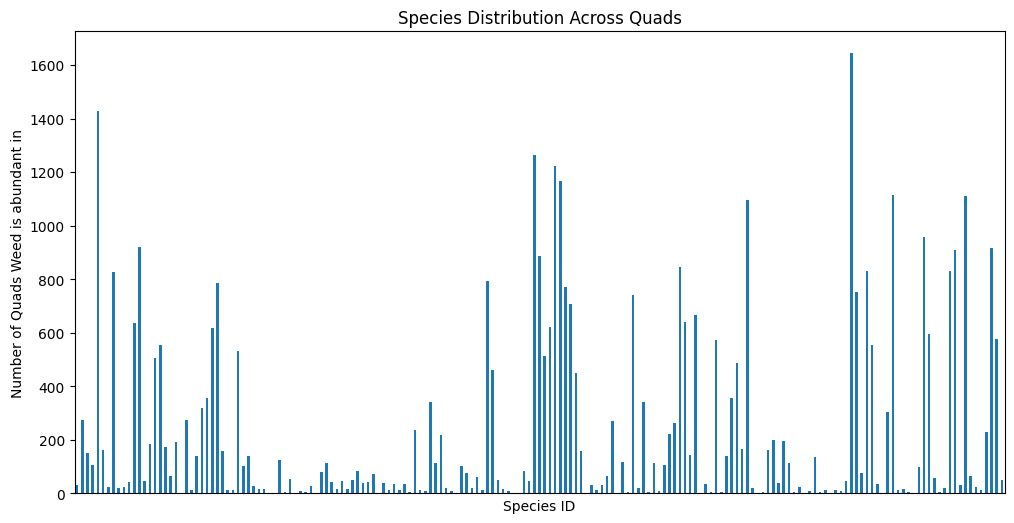

In [63]:
# Group by species_id and count number of unique quad_ids
species_quad = weeds[weeds["ABUNDANCE"] > 1].groupby("SPECIES_ID")["QUAD_ID"].nunique()

# Plot bar chart
plt.figure(figsize=(12, 6))
species_quad.plot(kind="bar")
plt.xticks([], [])
plt.xlabel("Species ID")
plt.ylabel("Number of Quads Weed is abundant in")
# plt.yscale("log")
plt.title("Species Distribution Across Quads")

In [64]:
california = gpd.read_file("/CA_State.shp")
california = california.to_crs(epsg = 3857)
fires = gpd.read_file("/Perimeters.shp")
fires = fires[fires.is_valid]
fires = fires.to_crs(epsg = 3857)

<Axes: >

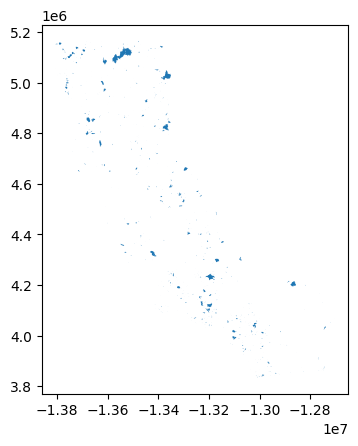

In [65]:
intersection = gpd.sjoin(fires, california, how='inner')

intersection.plot()

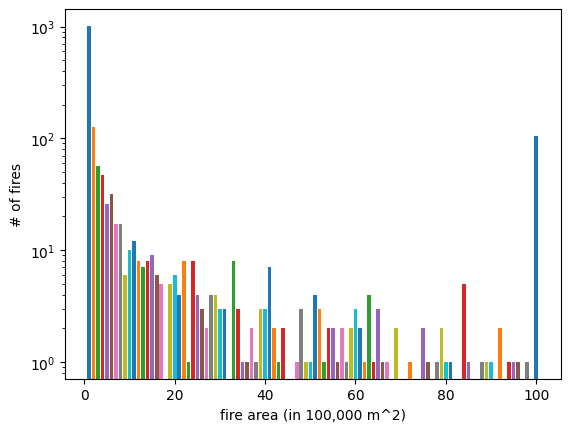

In [66]:
intersection["area"] = intersection.geometry.area


reigons = [i*(100000) for i in range(101)]


for i in range(1, 101):
    plt.bar(i, len(intersection[intersection["area"]<=reigons[i]][intersection["area"]>reigons[i-1]]))
plt.bar(i, len(intersection[intersection["area"]>reigons[-1]]))

plt.xlabel("fire area (in 100,000 m^2)")
plt.ylabel("# of fires")
plt.yscale("log")
plt.show()

In [67]:
#For each weed, if a fire was in a quad and the weed was in a quad, +1
weeds_by_species = weeds[weeds["ABUNDANCE"] > 1].to_crs(intersection.crs)

for i in range(len(intersection)):
    weeds_by_species[f"intersects_target {i}"] = weeds_by_species.geometry.intersects(intersection.geometry.iloc[i]).astype(int)

In [68]:
weeds_by_species["fires"] = weeds_by_species[[f"intersects_target {i}" for i in range(len(intersection))]].sum(axis = 1)

# print(sum(weeds_by_species[weeds_by_species["SPECIES_ID"] == 1]["fires"]))

species_fire_count = [sum(weeds_by_species[weeds_by_species["SPECIES_ID"] == i]["fires"]) for i in list(set(weeds_by_species["SPECIES_ID"]))]

In [69]:
species_fire_count[0]

19

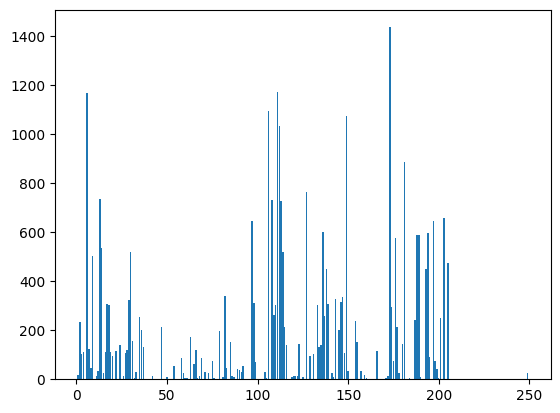

In [70]:

plt.bar(list(set(weeds_by_species["SPECIES_ID"])), species_fire_count)
plt.show()

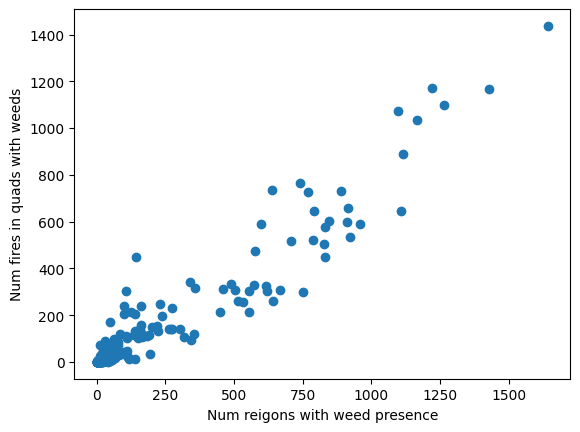

In [71]:
plt.scatter(species_quad,species_fire_count)
plt.xlabel("Num reigons with weed presence")
plt.ylabel("Num fires in quads with weeds")
plt.show()

In [72]:
# -*- coding: utf-8 -*-
""" Full KNN pipeline starting from your weeds selection """

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter

warnings.filterwarnings('ignore')

# 1) Load the shapefiles
gdf = gpd.read_file("/quads3310-20131231.shp")
california = gpd.read_file("/CA_State.shp").to_crs(epsg=3857)
fires = gpd.read_file("/Perimeters.shp")
fires = fires[fires.is_valid].to_crs(epsg=3857)

# 2) Extract and clean the “weeds” table
weeds = gdf[['ID', 'SPECIES_ID', 'QUAD_ID', 'ABUNDANCE',
             'SPREAD', 'DATE', 'geometry']]
weeds = weeds[weeds['ABUNDANCE'] != 9]  # Remove unidentified
print(f"Num Species: {weeds['SPECIES_ID'].nunique()}, Num Regions: {weeds['QUAD_ID'].nunique()}")

# 3) Compute “# of quads per species” for abundant weeds
weeds_abund = weeds[weeds['ABUNDANCE'] > 1]
species_quad = weeds_abund.groupby('SPECIES_ID')['QUAD_ID'].nunique()

# 4) Find fires that intersect California
intersection = gpd.sjoin(fires, california, how='inner')
intersection['area'] = intersection.geometry.area  # optional, if you want area bins

# 5) For each weed‐record, count how many of these fires it falls in
weeds_abund = weeds_abund.to_crs(intersection.crs)
for idx, fire_geom in intersection.geometry.items():     # ← items() instead of iteritems()
    weeds_abund[f'intersects_{idx}'] = (
        weeds_abund.geometry.intersects(fire_geom).astype(int)
    )
weeds_abund['fires'] = weeds_abund.filter(like='intersects_').sum(axis=1)


# 6) Compute “# of fires per species”
species_fire = weeds_abund.groupby('SPECIES_ID')['fires'].sum()

# 7) Build feature matrix X and label vector y
# ───────────────────────────────────────────────

unique_species = sorted(species_quad.index)
region_counts = np.array([species_quad.loc[s] for s in unique_species])
fire_counts   = np.array([species_fire.loc[s] for s in unique_species])

# Binary label: 1 if above‐median fire count, else 0
median_fire = np.median(fire_counts)
y = (fire_counts > median_fire).astype(int)

# Feature matrix: [#quads, #fires]
X = np.column_stack((region_counts, fire_counts))

# 8) KNN implementation
def euclidean_distance(A, b):
    return np.sqrt(np.sum((A - b)**2, axis=1))

def knn_predict_point(x_new, X_train, y_train, k=3):
    dists = euclidean_distance(X_train, x_new)
    k_idx = np.argsort(dists)[:k]
    return Counter(y_train[k_idx]).most_common(1)[0][0]

def knn_predict(X_test, X_train, y_train, k=3):
    return np.array([knn_predict_point(x, X_train, y_train, k)
                     for x in X_test])

# 9) Train/test split and evaluate
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

y_pred = knn_predict(X_test, X_train, y_train, k=5)
accuracy = np.mean(y_pred == y_test)
print(f"KNN accuracy: {accuracy:.2%}")


Num Species: 265, Num Regions: 2856
KNN accuracy: 100.00%


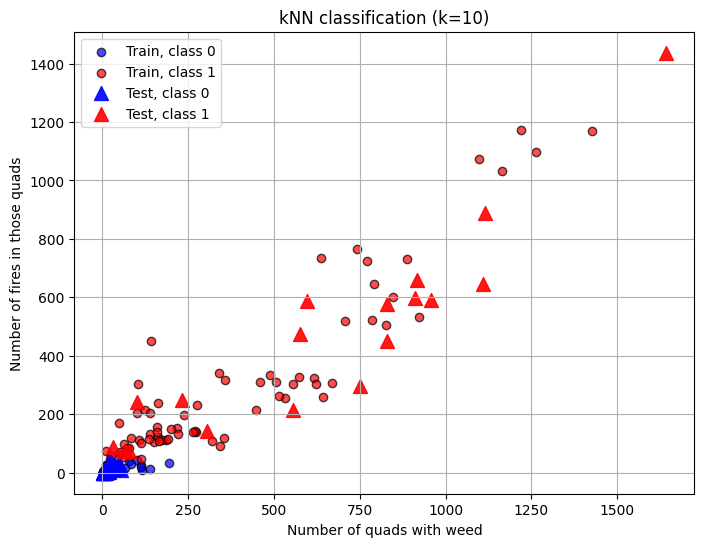

In [73]:
plt.figure(figsize=(8,6))

# Plot TRAINING points, class 0 and 1
for cl, marker in [(0,'o'), (1,'o')]:
    sel = (y_train == cl)
    plt.scatter(
        X_train[sel,0], X_train[sel,1],
        c=['blue','red'][cl],            # blue for 0, red for 1
        marker=marker,
        label=f"Train, class {cl}",
        edgecolor='k', alpha=0.7
    )

# Plot TEST points, class 0 and 1
for cl, marker in [(0,'^'), (1,'^')]:
    sel = (y_pred == cl)
    plt.scatter(
        X_test[sel,0], X_test[sel,1],
        c=['blue','red'][cl],
        marker=marker,
        s=100,
        label=f"Test, class {cl}",
        alpha=0.9
    )

plt.xlabel("Number of quads with weed")
plt.ylabel("Number of fires in those quads")
plt.title(f"kNN classification (k={k})")
plt.legend()
plt.grid(True)
plt.show()



In [74]:
# 7) Define a 4-class label by quartiles of fire_counts
# ───────────────────────────────────────────────
import numpy as np

# compute the 25th, 50th, and 75th percentiles
q1, q2, q3 = np.percentile(fire_counts, [25, 50, 75])

# digitize into 4 bins:
#  0 if fire_counts <= q1
#  1 if q1 < fire_counts <= q2
#  2 if q2 < fire_counts <= q3
#  3 if fire_counts > q3
y4 = np.digitize(fire_counts, bins=[q1, q2, q3])

# now y4 is an array of 0,1,2,3
print("Class distribution:", np.bincount(y4))
X = np.column_stack((region_counts, fire_counts))
y = y4        # <-- use 4-class labels now

# train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Class distribution: [43 46 45 45]


In [75]:
# ───────────────────────────────────────────────
# 7) Define a 4-class label by quartiles of fire_counts
# ───────────────────────────────────────────────
import numpy as np

# compute the 25th, 50th, and 75th percentiles
q1, q2, q3 = np.percentile(fire_counts, [25, 50, 75])

# digitize into 4 bins:
#  0 if fire_counts <= q1
#  1 if q1 < fire_counts <= q2
#  2 if q2 < fire_counts <= q3
#  3 if fire_counts > q3
y4 = np.digitize(fire_counts, bins=[q1, q2, q3])

# now y4 is an array of 0,1,2,3
print("Class distribution:", np.bincount(y4))


Class distribution: [43 46 45 45]


In [76]:
X = np.column_stack((region_counts, fire_counts))
y = y4        # <-- use 4-class labels now

# train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


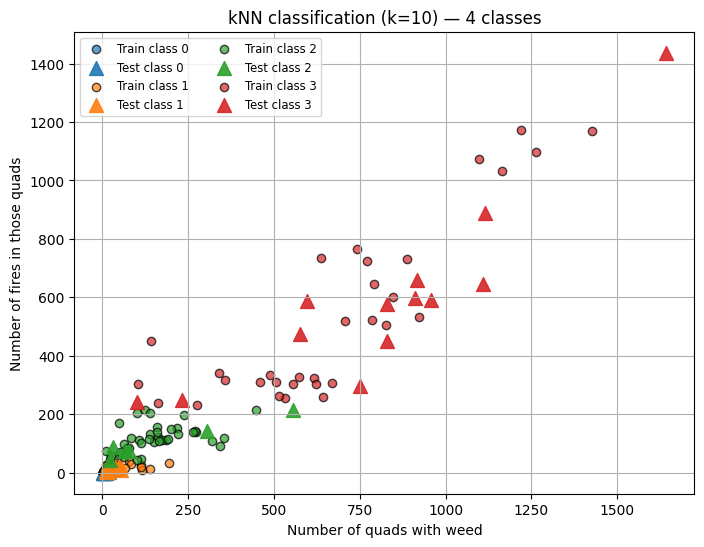

Species in class 0: [10, 23, 40, 41, 43, 45, 48, 51, 52, 53, 55, 64, 78, 88, 94, 100, 101, 102, 103, 118, 124, 126, 128, 130, 132, 140, 144, 151, 152, 156, 163, 164, 165, 167, 168, 169, 170, 179, 182, 185, 186, 191, 192]
Species in class 1: [1, 11, 12, 15, 25, 26, 32, 33, 42, 50, 59, 60, 61, 67, 68, 70, 71, 73, 74, 76, 80, 81, 86, 87, 90, 91, 104, 105, 119, 120, 121, 122, 125, 141, 142, 150, 157, 159, 160, 171, 172, 178, 184, 190, 200, 249]
Species in class 2: [3, 4, 7, 8, 16, 19, 20, 22, 24, 27, 28, 31, 36, 37, 47, 54, 58, 63, 65, 66, 69, 75, 79, 83, 85, 89, 92, 99, 115, 116, 123, 129, 131, 134, 135, 145, 148, 155, 166, 175, 177, 180, 195, 198, 199]
Species in class 3: [2, 6, 9, 13, 14, 17, 18, 29, 30, 35, 82, 97, 98, 106, 108, 109, 110, 111, 112, 113, 114, 127, 133, 136, 137, 138, 139, 143, 146, 147, 149, 154, 173, 174, 176, 181, 187, 188, 189, 193, 194, 197, 201, 203, 205]


In [77]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
for cls in range(4):
    sel_tr = y_train == cls
    sel_te = y_test == cls
    # Get color from tab10 colormap for the current class
    color = plt.cm.tab10(cls)
    plt.scatter(
        X_train[sel_tr, 0],
        X_train[sel_tr, 1],
        label=f"Train class {cls}",
        marker="o",
        color=color,  # Use the color from tab10
        edgecolor="k",
        alpha=0.7,
    )
    plt.scatter(
        X_test[sel_te, 0],
        X_test[sel_te, 1],
        label=f"Test class {cls}",
        marker="^",
        color=color,  # Use the color from tab10
        s=100,
        alpha=0.9,
    )

plt.xlabel("Number of quads with weed")
plt.ylabel("Number of fires in those quads")
plt.title(f"kNN classification (k={k}) — 4 classes")
plt.legend(ncol=2, fontsize="small")
plt.grid(True)
plt.show()

for cls in range(4):
    # Get indices of species in the current class
    indices_in_class = np.where(y == cls)[0]
    # Get the corresponding species IDs using the indices
    species_in_class = [unique_species[i] for i in indices_in_class]
    print(f"Species in class {cls}: {species_in_class}")
